<a href="https://colab.research.google.com/github/appersaravanan/Semeter-2-Assignment-1/blob/master/A4_VGG16_SENet_submission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import  MaxPooling2D,UpSampling2D,Input,BatchNormalization,\
Conv2D,Activation,MaxPool2D,Flatten,Dense,GlobalAveragePooling2D,Lambda,Concatenate,GlobalMaxPooling2D,Add,multiply,Dropout
from tensorflow.keras.models import Model,Sequential,load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import cifar10
import matplotlib.pyplot as plt
from keras.utils import np_utils
from keras.preprocessing import image as image_utils
from keras.applications.imagenet_utils import decode_predictions
from keras.applications.imagenet_utils import preprocess_input
from keras.applications import VGG16
import cv2,os,tempfile
import requests
from keras.preprocessing import image
import tensorflow_datasets as tfds

In [3]:
vgg_model = VGG16(include_top=True,weights="imagenet")
#vgg_model.summary()


553467904/553467096 [==============================] - 4s 0us/step


#Squeeze-And-Excitation Block
* Squeeze:
     *  Channel size is deteced from tensor parameter and by default ,VGG16  is Channel_last so get the channel details from the tensor.shape

     GlobalAveragePooling2D()(init) -  this layer is responsible to squeeze  for each channel and get the single vector with size of the channel  like in our case (64,128,256,512,512) size
     Reshape bring back to vgg compatiable dimension
* Excitation
     *  The below layer adds nonLinerity between the channel by reducing it in certain ratio

      se = Dense(filters // ratio, activation='relu')(se)

      This layers adds sigmoid activations which helps to learn the non-mutually-exclusive relationship in the multiple channels

      se = Dense(filters, activation='sigmoid')(se) 
   





In [4]:
def squeeze_excite_block(tensor, drop_out=False, ratio=16):
    init = tensor
    channel_axis = -1
    filters = init.shape[channel_axis]
    se_shape = (1, 1, filters)

    se = GlobalAveragePooling2D()(init)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation='relu')(se)
    se = Dense(filters, activation='sigmoid')(se)  
    # if drop_out == True:
    #  se = Dropout(0.4)(se)
    x = multiply([init, se])
    return x

##VGG16's pretrained layers are freezed and only new SENet block layer and last dense(prediction) layer will be trained with data set

In [5]:
from tensorflow.keras.layers import  Reshape
vgg_model.trainable =False


#x=squeeze_excite_block(vgg_model.layers[0].output)
x=vgg_model.layers[0].output
# x=squeeze_excite_block(x,True)
x=vgg_model.layers[1](x)
x=vgg_model.layers[2](x)
x=vgg_model.layers[3](x)
x=squeeze_excite_block(x,True)
x=vgg_model.layers[4](x)
x=vgg_model.layers[5](x)
x=vgg_model.layers[6](x)
x=squeeze_excite_block(x,True)
x=vgg_model.layers[7](x)
x=vgg_model.layers[8](x)
x=vgg_model.layers[9](x)
x=vgg_model.layers[10](x)
x=squeeze_excite_block(x,True)
x=vgg_model.layers[11](x)
x=vgg_model.layers[12](x)
x=vgg_model.layers[13](x)
x=vgg_model.layers[14](x)
x=squeeze_excite_block(x,True)
x=vgg_model.layers[15](x)
x=vgg_model.layers[16](x)
x=vgg_model.layers[17](x)
x=vgg_model.layers[18](x)
x=squeeze_excite_block(x,True)
x=vgg_model.layers[19](x)
x=vgg_model.layers[20](x)
x=vgg_model.layers[21](x)
x=Dense(10,activation='softmax')(x)
senet_model = Model(vgg_model.input, x)
     
senet_model.compile(
    optimizer='adam',    
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

senet_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[1][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[1][0]               
______________________________________________________________________________________________

## Loading Imagenette dataset and convert to each 224*224 (Height * width) that is compatiable to VGG16 input format
 Imagenette contains train and validation 

In [6]:
imagenette_builder = tfds.builder("imagenette/full-size")
imagenette_info = imagenette_builder.info
imagenette_builder.download_and_prepare()
datasets = imagenette_builder.as_dataset(as_supervised=True)
train_data , test_data =datasets['train'],datasets['validation']




Shuffling and writing examples to /root/tensorflow_datasets/imagenette/full-size/0.1.0.incompleteX4NH77/imagenette-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imagenette/full-size/0.1.0.incompleteX4NH77/imagenette-validation.tfrecord


Dataset imagenette downloaded and prepared to /root/tensorflow_datasets/imagenette/full-size/0.1.0. Subsequent calls will reuse this data.


In [7]:
#utility method to convert images into 224*224 format
def normalize_img(image, label):  
  image1=tf.cast(tf.image.resize(image, (224, 224)), tf.float32) / 255., label   
  print(image1)   
  print(label)
  return  image1

# Train data batched and converted to PrefectDataset

In [8]:

ds_train = train_data.map(
   normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)




(<tf.Tensor 'truediv:0' shape=(224, 224, 3) dtype=float32>, <tf.Tensor 'args_1:0' shape=() dtype=int64>)
Tensor("args_1:0", shape=(), dtype=int64)


# Validation data batched and converted to PrefectDataset

In [9]:
test_data=datasets['validation']
ds_test= test_data.map(
   normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_test = ds_test.batch(128)
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

(<tf.Tensor 'truediv:0' shape=(224, 224, 3) dtype=float32>, <tf.Tensor 'args_1:0' shape=() dtype=int64>)
Tensor("args_1:0", shape=(), dtype=int64)


#SENet model trained with train and validation data set

In [10]:
from keras.callbacks import EarlyStopping

senet_model.fit(
    ds_train, 
    validation_data=ds_test, 
    shuffle=True,
    epochs=50,
    batch_size=128
)

Epoch 1/50
101/101 [==============================] - 89s 613ms/step - loss: 2.1658 - accuracy: 0.2285 - val_loss: 0.9340 - val_accuracy: 0.7060
Epoch 2/50
101/101 [==============================] - 46s 452ms/step - loss: 0.8590 - accuracy: 0.7092 - val_loss: 0.5032 - val_accuracy: 0.8560
Epoch 3/50
101/101 [==============================] - 46s 453ms/step - loss: 0.5225 - accuracy: 0.8348 - val_loss: 0.4011 - val_accuracy: 0.8800
Epoch 4/50
101/101 [==============================] - 46s 453ms/step - loss: 0.3998 - accuracy: 0.8733 - val_loss: 0.3543 - val_accuracy: 0.8900
Epoch 5/50
101/101 [==============================] - 46s 452ms/step - loss: 0.3377 - accuracy: 0.8938 - val_loss: 0.3254 - val_accuracy: 0.8960
Epoch 6/50
101/101 [==============================] - 46s 453ms/step - loss: 0.2942 - accuracy: 0.9065 - val_loss: 0.3148 - val_accuracy: 0.9020
Epoch 7/50
101/101 [==============================] - 46s 453ms/step - loss: 0.2626 - accuracy: 0.9164 - val_loss: 0.3088 - val_ac

In [11]:
from google.colab import drive
drive.mount('/content/gdrive')
senet_model.save('./sapper_saved_model/senet_model') 
senet_model = tf.keras.models.load_model('sapper_saved_model/senet_model')
senet_model.summary()

Mounted at /content/gdrive
INFO:tensorflow:Assets written to: ./sapper_saved_model/senet_model/assets


INFO:tensorflow:Assets written to: ./sapper_saved_model/senet_model/assets


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
______________________________________________________________________________________________

# VGG16 model's prediction layers support 1000 Classes but Imagenette contains 10 Classes so only replacing the last layer with new dense layer with 10 classes it helps to compare both model predictions easily

We are only training the new last Dense layer  and all other layers are Trainable is false


In [12]:
copy_model_vgg = Sequential()
for layer in vgg_model.layers[:-1]:
    copy_model_vgg.add(layer)
for layer in copy_model_vgg.layers:
    layer.trainable = False
copy_model_vgg.add(Dense(units=10, activation='softmax'))
copy_model_vgg.compile(
    optimizer='adam',    
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

copy_model_vgg.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

In [13]:
copy_model_vgg.fit(
    ds_train, 
    validation_data=ds_test, 
    shuffle=True,
    epochs=50,
    batch_size=128
)

Epoch 1/50
101/101 [==============================] - 25s 236ms/step - loss: 1.5903 - accuracy: 0.4911 - val_loss: 0.7185 - val_accuracy: 0.7820
Epoch 2/50
101/101 [==============================] - 24s 235ms/step - loss: 0.6878 - accuracy: 0.7905 - val_loss: 0.5727 - val_accuracy: 0.8340
Epoch 3/50
101/101 [==============================] - 24s 234ms/step - loss: 0.5694 - accuracy: 0.8251 - val_loss: 0.5055 - val_accuracy: 0.8660
Epoch 4/50
101/101 [==============================] - 24s 235ms/step - loss: 0.5114 - accuracy: 0.8437 - val_loss: 0.4665 - val_accuracy: 0.8700
Epoch 5/50
101/101 [==============================] - 24s 231ms/step - loss: 0.4744 - accuracy: 0.8535 - val_loss: 0.4403 - val_accuracy: 0.8700
Epoch 6/50
101/101 [==============================] - 24s 235ms/step - loss: 0.4478 - accuracy: 0.8621 - val_loss: 0.4208 - val_accuracy: 0.8720
Epoch 7/50
101/101 [==============================] - 24s 234ms/step - loss: 0.4272 - accuracy: 0.8690 - val_loss: 0.4055 - val_ac

In [14]:
from google.colab import drive
drive.mount('/content/gdrive')
copy_model_vgg.save('./sapper_saved_model/copy_model_vgg') 

copy_model_vgg = tf.keras.models.load_model('sapper_saved_model/copy_model_vgg')
copy_model_vgg.summary()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
INFO:tensorflow:Assets written to: ./sapper_saved_model/copy_model_vgg/assets


INFO:tensorflow:Assets written to: ./sapper_saved_model/copy_model_vgg/assets


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

###Custom decode_prediction to support 10 classes. We can use decode_prediction method from Imagenet but it only support with 1000 classes but Our input contains 10 classes

In [15]:

from tensorflow.python.keras.utils import data_utils
import json
CLASS_INDEX= {
            '0':  ['n01440764', 'tench'],
            '1':  ['n02102040', 'English_springer'],
            '2':  ['n02979186',  'casette_player'],
            '3':  ['n03000684', 'chain_saw'],
            '4':  ['n03028079',  'church'],
            '5':  ['n03394916',  'French_horn'],
            '6':  ['n03417042',  'garbage_truck'],
            '7':  ['n03425413',  'gas_pump'],
            '8':  ['n03445777',  'golf_ball'],
            '9':  ['n03888257', 'parachute']
        }



def my_decode_predictions(preds, top=5, **kwargs): 
  
    

    # print(CLASS_INDEX)
    results = []
    for pred in preds:
        top_indices = pred.argsort()[-top:][::-1]
        result = [tuple(CLASS_INDEX[str(i)]) + (pred[i],) for i in top_indices]
        result.sort(key=lambda x: x[2], reverse=True)
        results.append(result)
    return results


In [16]:
senet_model_prediction = senet_model.predict(ds_test)
copy_model_vgg_prediction= copy_model_vgg.predict(ds_test) 

In [17]:
senet_model_pred_round= np.round(senet_model_prediction)
vgg_copy_model_pred_round=np.round(copy_model_vgg_prediction)
print(senet_model_prediction.shape)
print(vgg_copy_model_pred_round.shape)


(500, 10)
(500, 10)


###Compare both vgg_model and new model predictions

#Using first 30 images from validation-set to use for  predictions

In [18]:
# K.clear_session()
# tf.compat.v1.reset_default_graph()
# tf.compat.v1.enable_eager_execution()
test_data=datasets['validation']
ds_test1= test_data.map(
   normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
t=ds_test1.take(30)




(<tf.Tensor 'truediv:0' shape=(224, 224, 3) dtype=float32>, <tf.Tensor 'args_1:0' shape=() dtype=int64>)
Tensor("args_1:0", shape=(), dtype=int64)


1


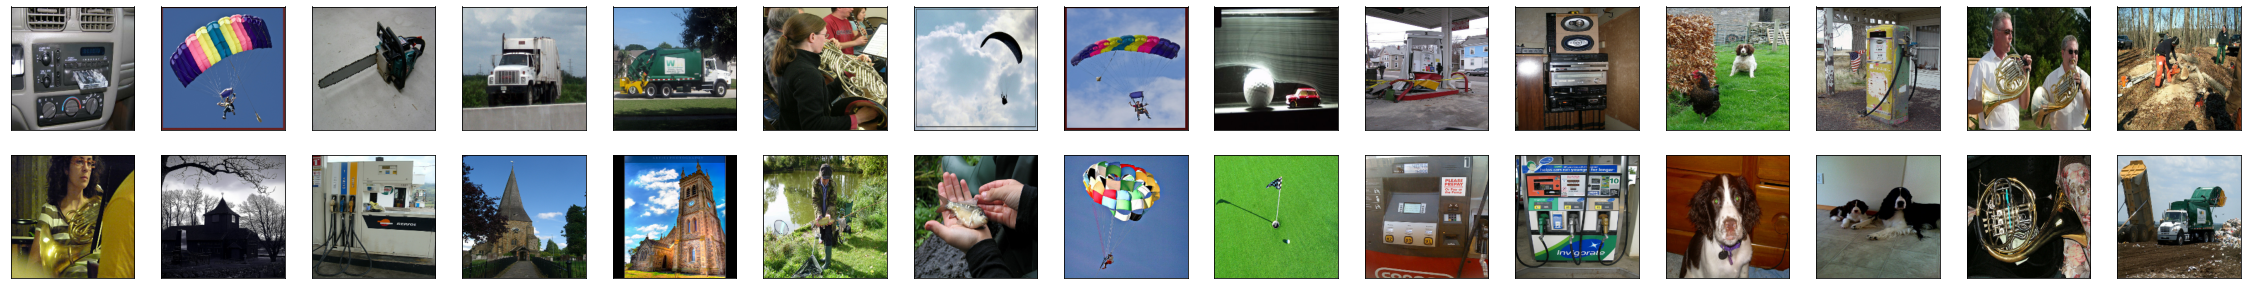

In [19]:
def compareImage(orig,  title,num=10):   
    columns= n = num
    if n>10 :
       columns=n/2;
    plt.figure(figsize=(40, 5))
    print ('\033[1m' + title)
    for i in range(n):
        ax = plt.subplot(2, columns, i+1)
        plt.imshow(orig[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

input_images_array=[]

for imagedata, label in tfds.as_numpy(t):  # example is (image, label)
  input_images_array.append(imagedata) 
  img2 =imagedata.copy()
 
compareImage(input_images_array,"1",30)


#Compare the predcition output of both models and show the image only if both model prediction is not equal. 

0
0 Both model matched  casette_player  =  casette_player
1
1 Both model matched  parachute  =  parachute
2
2 Both model matched  chain_saw  =  chain_saw
3
3 Both model matched  garbage_truck  =  garbage_truck
4
4 Both model matched  garbage_truck  =  garbage_truck
5
5 Both model matched  French_horn  =  French_horn
6
6 Both model matched  parachute  =  parachute
7
7 Both model matched  parachute  =  parachute
8
8 Both model matched  golf_ball  =  golf_ball
9
9 Both model matched  gas_pump  =  gas_pump
10
10 Both model matched  casette_player  =  casette_player
11
11 Both model matched  English_springer  =  English_springer
12
12 Both model matched  gas_pump  =  gas_pump
13
13 Both model matched  French_horn  =  French_horn
14
SENet Prediction - chain_saw  =  English_springer VGG Prediction


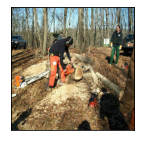

15
15 Both model matched  French_horn  =  French_horn
16
16 Both model matched  church  =  church
17
17 Both model matched  gas_pump  =  gas_pump
18
18 Both model matched  church  =  church
19
19 Both model matched  church  =  church
20
20 Both model matched  chain_saw  =  chain_saw
21
SENet Prediction - tench  =  English_springer VGG Prediction


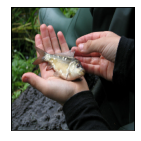

22
22 Both model matched  parachute  =  parachute
23
SENet Prediction - golf_ball  =  parachute VGG Prediction


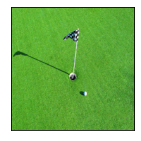

24
24 Both model matched  gas_pump  =  gas_pump
25
25 Both model matched  gas_pump  =  gas_pump
26
26 Both model matched  English_springer  =  English_springer
27
27 Both model matched  English_springer  =  English_springer
28
28 Both model matched  French_horn  =  French_horn
29
29 Both model matched  garbage_truck  =  garbage_truck


In [20]:

for i in range(len(input_images_array)):
  print(i)
  vgg_prediction=copy_model_vgg.predict(input_images_array[i][np.newaxis,...])
  vgg_value= np.round(vgg_prediction)
 
  senet_model_pred=senet_model.predict(input_images_array[i][np.newaxis,...])  
  senet_model_pred_value= np.round(senet_model_pred)
 
  senet_value = np.where(senet_model_pred_value[0] ==1)[0][0];
  vgg_value = np.where(vgg_value[0] ==1)[0][0]
  # print((senet_value))
  senet_value =CLASS_INDEX[str(senet_value)][1]
  vgg_value = CLASS_INDEX[str(vgg_value)][1]
 
  if senet_value !=vgg_value:
     predictions= "SENet Prediction - "+ str(senet_value) + "  =  " + str(vgg_value) +" VGG Prediction"
     compareImage([input_images_array[i]],predictions,1)
  else:
      print(str(i) +" Both model matched  "+ str(senet_value) + "  =  " + str(vgg_value)    )


In [21]:
senet_model.predict(input_images_array[14][np.newaxis,...])
np.round(senet_model_pred)

array([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]], dtype=float32)


# Optional
Additional logic to check entire prediction of both model and find out how many are not matching between each other

In [22]:
mismatch_count=0;
for i in range(30):
   #print(str(i+1) +"New model"+ str(np.where(new_model_value[i] ==1)) + " VGG Prediction " + str(np.where(copy_new_model_value[i]==1)) )
   new_model_hot_index= np.where(senet_model_pred_round[i] ==1)
   vgg_model_hot_index= np.where(vgg_copy_model_pred_round[i]==1)
   newmodeL_pre=vggmodeL_pre=-1;
   if len(new_model_hot_index)>0:
      newmodeL_pre=new_model_hot_index[0]
   if len(vgg_model_hot_index)>0:
      vggmodeL_pre=vgg_model_hot_index[0]
   if new_model_hot_index !=vgg_model_hot_index :
      mismatch_count=mismatch_count+1;
      print(str(i+1) +"New model vs VGG Prediction "+ str(new_model_hot_index) +" vs " +str(vgg_model_hot_index))
print(mismatch_count)

15New model vs VGG Prediction (array([3]),) vs (array([1]),)
22New model vs VGG Prediction (array([0]),) vs (array([1]),)
24New model vs VGG Prediction (array([8]),) vs (array([9]),)
3


SENet model predction for feature map

In [23]:
senet_prediction_output_arr=[]
senet_prediction_output_decoded_arr=[]
for i in range(len(input_images_array)): 
 # print(test_images_array[i].shape)
  prediction_result= senet_model.predict(input_images_array[i][np.newaxis,...])  
  prediction_result=np.round(prediction_result)
  #print(prediction_result)
  senet_prediction_output_arr.append(prediction_result)
  prediction_output=my_decode_predictions(prediction_result)
  
  senet_prediction_output_decoded_arr.append(prediction_output)
 



VGG16 model predction for feature map

In [24]:
vgg_prediction_output_arr=[]
vgg_prediction_output_decoded_arr=[]
for i in range(len(input_images_array)): 
  prediction_result= copy_model_vgg.predict(input_images_array[i][np.newaxis,...])  
  prediction_result=np.round(prediction_result)  
  vgg_prediction_output_arr.append(prediction_result)
  prediction_output=my_decode_predictions(prediction_result)
  vgg_prediction_output_decoded_arr.append(prediction_output)
  


# Code to display the layers feature 

In [25]:
import keras.backend as K
from vis.utils import utils

def plot_map(input_image,grads1,grads2, grads3,grads4,grads5,grads6, grads7,grads8):
    fig, axes = plt.subplots(1,9,figsize=(14,5))
    axes[0].imshow(input_image)
    axes[1].imshow(input_image)
    axes[2].imshow(input_image)
    axes[3].imshow(input_image)
    axes[4].imshow(input_image)
    axes[5].imshow(input_image)
    axes[6].imshow(input_image)
    axes[7].imshow(input_image)
    axes[8].imshow(input_image)
    
    i = axes[1].imshow(grads1,cmap="jet",alpha=0.8)
    i = axes[2].imshow(grads2,cmap="jet",alpha=0.8)
    i = axes[3].imshow(grads3,cmap="jet",alpha=0.8)
    i = axes[4].imshow(grads4,cmap="jet",alpha=0.8)
    i = axes[5].imshow(grads5,cmap="jet",alpha=0.8)
    i = axes[6].imshow(grads6,cmap="jet",alpha=0.8)
    i = axes[7].imshow(grads7,cmap="jet",alpha=0.8)
    i = axes[8].imshow(grads8,cmap="jet",alpha=0.8)
   
    #fig.colorbar(i)

# Utility to search for layer index by name. 
# Alternatively we can specify this as -1 since it corresponds to the last layer.


# Feature map extraction logic (I used this instead on keras-vis framework)

In [26]:

tf.compat.v1.disable_eager_execution()
def heatMap(model,layer_name,image_input,prediction_output):
  layer_idx = utils.find_layer_idx(model, layer_name)
  #print(layer_idx)
  ## select class of interest
  class_idx_array = np.argsort(prediction_output.flatten())[::-1]
  class_idx =class_idx_array[0]
  ## define derivative d loss / d layer_input
  layer_input       = model.input
  #print(layer_input)
  ## This model must already use linear activation for the final layer
  loss              = model.layers[layer_idx].output[...,class_idx]
  grad_tensor       = K.gradients(loss,layer_input)[0]
  #print(grad_tensor)
  #print(grad_tensor[0])
  ## create function that evaluate the gradient for a given input
  # This function accept numpy array
  derivative_fn     = K.function([layer_input],[grad_tensor])

  ## evaluate the derivative_fn
  grad_eval_by_hand = derivative_fn([image_input[np.newaxis,...]])[0]
  #print(grad_eval_by_hand.shape)


  grad_eval_by_hand = np.abs(grad_eval_by_hand).max(axis=(0,3))

  ## normalize to range between 0 and 1
  arr_min, arr_max  = np.min(grad_eval_by_hand), np.max(grad_eval_by_hand)
  grad_eval_by_hand = (grad_eval_by_hand - arr_min) / (arr_max - arr_min + K.epsilon())
  return grad_eval_by_hand

In [ ]:



input_image=input_images_array[0]
prediction=senet_prediction_output_arr[0]
plot_map(input_image,heatMap(senet_model,'block1_pool',input_image,prediction),heatMap(senet_model,'block2_conv1',input_image,prediction),\
                      heatMap(senet_model,'block2_pool',input_image,prediction),heatMap(senet_model,'block3_conv1',input_image,prediction),\
                      heatMap(senet_model,'block3_pool',input_image,prediction),heatMap(senet_model,'block4_conv1',input_image,prediction),\
                      heatMap(senet_model,'block4_pool',input_image,prediction),heatMap(senet_model,'block5_conv1',input_image,prediction))

print ('\033[1m'+"senet_model")
input_image=input_images_array[21]
prediction=senet_prediction_output_arr[21]
plot_map(input_image,heatMap(senet_model,'block1_pool',input_image,prediction),heatMap(senet_model,'block2_conv1',input_image,prediction),\
                      heatMap(senet_model,'block2_pool',input_image,prediction),heatMap(senet_model,'block3_conv1',input_image,prediction),\
                      heatMap(senet_model,'block3_pool',input_image,prediction),heatMap(senet_model,'block4_conv1',input_image,prediction),\
                      heatMap(senet_model,'block4_pool',input_image,prediction),heatMap(senet_model,'block5_conv1',input_image,prediction))

input_image=input_images_array[23]
prediction=senet_prediction_output_arr[23]
plot_map(input_image,heatMap(senet_model,'block1_pool',input_image,prediction),heatMap(senet_model,'block2_conv1',input_image,prediction),\
                      heatMap(senet_model,'block2_pool',input_image,prediction),heatMap(senet_model,'block3_conv1',input_image,prediction),\
                      heatMap(senet_model,'block3_pool',input_image,prediction),heatMap(senet_model,'block4_conv1',input_image,prediction),\
                      heatMap(senet_model,'block4_pool',input_image,prediction),heatMap(senet_model,'block5_conv1',input_image,prediction))


In [ ]:
#print ('\033[1m'+"senet_model")
input_image=input_images_array[21]
prediction=senet_prediction_output_arr[21]
plot_map(input_image,heatMap(senet_model,'block1_pool',input_image,prediction),heatMap(senet_model,'block2_conv1',input_image,prediction),\
                      heatMap(senet_model,'block2_pool',input_image,prediction),heatMap(senet_model,'block3_conv1',input_image,prediction),\
                      heatMap(senet_model,'block3_pool',input_image,prediction),heatMap(senet_model,'block4_conv1',input_image,prediction),\
                      heatMap(senet_model,'block4_pool',input_image,prediction),heatMap(senet_model,'block5_conv1',input_image,prediction))
#print ('\033[1m'+" copy_model_vgg")
input_image=input_images_array[21]
prediction=senet_prediction_output_arr[21]
plot_map(input_image,heatMap(copy_model_vgg,'block1_pool',input_image,prediction),heatMap(copy_model_vgg,'block2_conv1',input_image,prediction),\
                      heatMap(copy_model_vgg,'block2_pool',input_image,prediction),heatMap(copy_model_vgg,'block3_conv1',input_image,prediction),\
                      heatMap(copy_model_vgg,'block3_pool',input_image,prediction),heatMap(copy_model_vgg,'block4_conv1',input_image,prediction),\
                      heatMap(copy_model_vgg,'block4_pool',input_image,prediction),heatMap(copy_model_vgg,'block5_conv1',input_image,prediction))
#print ('\033[1m'+"senet_model")
input_image=input_images_array[23]
prediction=senet_prediction_output_arr[23]
plot_map(input_image,heatMap(senet_model,'block1_pool',input_image,prediction),heatMap(senet_model,'block2_conv1',input_image,prediction),\
                      heatMap(senet_model,'block2_pool',input_image,prediction),heatMap(senet_model,'block3_conv1',input_image,prediction),\
                      heatMap(senet_model,'block3_pool',input_image,prediction),heatMap(senet_model,'block4_conv1',input_image,prediction),\
                      heatMap(senet_model,'block4_pool',input_image,prediction),heatMap(senet_model,'block5_conv1',input_image,prediction))
#print ('\033[1m'+" copy_model_vgg")
input_image=input_images_array[23]
prediction=senet_prediction_output_arr[23]
plot_map(input_image,heatMap(copy_model_vgg,'block1_pool',input_image,prediction),heatMap(copy_model_vgg,'block2_conv1',input_image,prediction),\
                      heatMap(copy_model_vgg,'block2_pool',input_image,prediction),heatMap(copy_model_vgg,'block3_conv1',input_image,prediction),\
                      heatMap(copy_model_vgg,'block3_pool',input_image,prediction),heatMap(copy_model_vgg,'block4_conv1',input_image,prediction),\
                      heatMap(copy_model_vgg,'block4_pool',input_image,prediction),heatMap(copy_model_vgg,'block5_conv1',input_image,prediction))